In [106]:
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from ipywidgets import interact, interactive
from preprocessing import TagGrouper, FeatureSelector
from plotting import plot_multilabel_classification_report, plot_scores
from sklearn.multiclass import OneVsRestClassifier

In [40]:
# Load classifiers
classifiers = {}

def load_meta(base_dir, file_name):
    path = os.path.join(base_dir, file_name + '.meta')
    with open(path, 'r') as f:
        return json.load(f)

def load_clf(base_dir, file_name):
    path = os.path.join(base_dir, file_name + '.pkl')
    return joblib.load(path)

def clfs_are_same_version(clfs):
    hashes = [classifier['meta']['git_hash'] for tag_id, classifier in classifiers.items()]
    return len(set(hashes)) == 1

for f in os.listdir("./models/"):
    if f.endswith(".pkl"):
        filename = os.path.splitext(f)[0]
        print('Loading model', filename)
        meta = load_meta('./models/', filename)
        clf = load_clf('./models/', filename)
        tag_id = meta['tag_id']
        classifiers[tag_id] = {
            'clf': clf,
            'meta': meta
        }
        
# Version verification
assert clfs_are_same_version(classifiers), 'Warning loaded classifiers were not generated on the same git hash!'

Loading model tag_5
Loading model tag_6
Loading model tag_3
Loading model tag_2
Loading model tag_1
Loading model tag_11
Loading model tag_9


---
## Import Dataset

In [57]:
# Import dataset
df = pd.read_csv('./data/features-total-2f8f6676.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,rawCommentLength,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,34.0,34.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,14.0,0.0,1.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,67.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,152.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,10.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


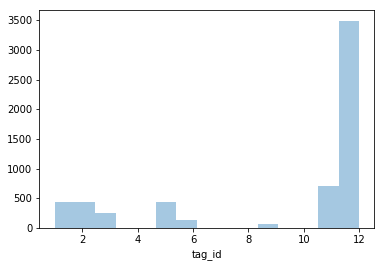

In [58]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

---
## Preprocessing

In [59]:
class TagGrouper2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['all_tags'] = X.groupby(['revision_id'])['tag_id'].apply(list)
        X = X.drop(['tag_id'], axis=1)
        X = X.groupby(['revision_id']).first()
        return X

    def fit_transform(self, X, y):
        return self.transform(X)


def preprocessing(features):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_columns)),
        ('tag_grouper', TagGrouper2())
    ])

    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'])
display(widget)

tags = [1, 2, 3, 5, 6, 9, 11, 12]
tag_names = ['blanking', 'nonesense', 'quality issue', 'false fact', 'syntax', 'edit war', 'intention', 'constructive']
print('Selected tags', tags)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Output()), _…

Selected tags [1, 2, 3, 5, 6, 9, 11, 12]


In [60]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))
processed_df.head()

Feature config: all , Features after preprocessing: 109


,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,rawCommentLength,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,all_tags
revision_id,,,,,,,,,,,,,,,,,,,,,
2148821,0.0,0.0,16.0,-1.0,1.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[12]
2359434,0.0,0.0,0.0,-1.0,3.0,-1.0,0.0,0.666667,0.666667,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,[12]
2880168,0.0,0.0,3.0,-1.0,1.0,-1.0,0.0,0.000000,0.000000,0.0,...,5.0,5.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,[12]
2970351,0.0,0.0,22.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,[12]
2975763,1.0,0.0,0.0,18.0,2.0,1.0,0.0,-1.000000,-1.000000,-1.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,"[2, 11, 1]"


In [61]:
# X, y split
X = processed_df.drop(['all_tags'], axis=1)
y = MultiLabelBinarizer().fit_transform(processed_df['all_tags'])

In [62]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3720, 108)
y train (3720, 8)
X test (1240, 108)
y test (1240, 8)


In [109]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
y_test_predict_unprocessed = []

# Train classifiers and make predicitions per tag
for i, e in enumerate(estimators):
    clf = e[1]
    # Retrain classifier on tag data
    y_train_tag = y_train[:, i]
    clf.fit(X_train, y_train_tag)
    
    # Predict tag for test
    predict = clf.predict(X_test)
    y_test_predict_unprocessed.append(predict)

In [110]:
def flatten_multilabel_predict_proba(y_score):
    result = []
    for i in range(len(y_score[0])):
        row = []
        for l in range(len(y_score)):
            row.append(y_score[l][i]) 
        result.append(row)
    return np.array(result)

In [111]:
y_test_predict = flatten_multilabel_predict_proba(y_test_predict_unprocessed)
y_test_predict

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 1]])

In [112]:
plot_multilabel_classification_report(y_test, y_test_predict, tag_names)

ValueError: Multi-label binary indicator input with different numbers of labels